In [1]:
import itertools
import math
import random
import numpy
import matplotlib
import matplotlib.pyplot as plt

# Step 1
Generate Rankings of Relevance for E and P


In [2]:
#Generating all possible combinations of relevance,
#where  0 - N, 1 - R, 2 - HR
possible_rankings = itertools.product([0,1,2], repeat=5)
P = [list(i) for i in possible_rankings]
E = P[:]

#Constructing all possible pairs
L = []
for item1 in P:
    for item2 in E:
        pair = []
        pair.append(item1)
        pair.append(item2)
        L.append(pair)
print "Number of possible rankings: ", len(L)

Number of possible rankings:  59049


# Step 2
Implement Evaluation Measures 

In [34]:
def precision(res, k = 5):
    counter = 0
    for i in range(k):
        if res[i] != 0:
            counter += 1
    return 1.0*counter / k

def DCG(res, k = 5):
    sum = 0
    for r in range(1,k+1):
        sum += (2**res[r-1] - 1)/math.log(1+r,2)
    return sum

def RBP(res, theta = 0.8):
    sum = 0
    for k in range(1, len(res)):
        sum += res[k-1] * theta**(k-1)*(1 - theta)
    return sum

N=1165
print "Example:"
print " Rankings: ", L[N]
print " Precision@4: ", [precision(L[N][0],k = 4), precision(L[N][1],k = 4)]
print " DCG@4: ", [DCG(L[N][0],k = 3),DCG(L[N][1],k = 4)]
print " RBP: ", [RBP(L[N][0]), RBP(L[N][1])]

Example:
 Rankings:  [[0, 0, 0, 1, 1], [2, 1, 0, 1, 1]]
 Precision@4:  [0.25, 0.75]
 DCG@4:  [0.0, 4.061606311644851]
 RBP:  [0.1024, 0.6623999999999999]


# Step 3
 Calculate the 𝛥measure

In [98]:
def delta_measure(pair,measure, k = 5):
    if measure == "precision":
        P = precision(pair[0], k)
        E = precision(pair[1], k)
    if measure == "DCG":
        P = DCG(pair[0], k)
        E = DCG(pair[1], k)
    if measure == "RBP":
        P = RBP(pair[0])
        E = RBP(pair[1])
    return E - P
    

def E_outperforms_G_pairs(pairs, measure, k=5):
    result = []
    for pair in pairs:
        diff = delta_measure(pair,measure,k)
        if diff > 0:
            result.append([pair, diff])
    return result



dcg_res = E_outperforms_G_pairs(L, "DCG")
prec_res = E_outperforms_G_pairs(L, "precision")
rbp_res = E_outperforms_G_pairs(L, "RBP")

N=5432
print "Example: "
# print " Rankings: ", res[N][0]
# print " DCG difference: ", res[N][1]

print "Number of pairs for which E outperforms P for different measures:"
print " Precision:", len(prec_res)
print " DCG:", len(dcg_res)
print " RBP:", len(rbp_res)

Example: 
Number of pairs for which E outperforms P for different measures:
 Precision: 21762
 DCG: 29376
 RBP: 29160


# Step 4
Implement Interleaving

In our implementations of the generic Team Draft Interleaving and Probabilistic Interleaving, we also consider overlapping documents between the two rankings. To find which documents are the same, we are comparing the labels of the documents.

To make use of this generic algorithm with our rankings, that have relevance as labels, we have to alter the labels so that each one of them is unique. We do that by appending a unique number next to the relevance. For example, the rankings pair:

[0, 0, 2, 2, 1], [2, 0, 2, 2, 2]

becomes

[00, 01, 22, 23, 14], [25, 06, 27, 28, 29]

In this way, we make sure that there are no overlapping documents between the two rankings, as is required by Note 5 a).

In [6]:
#Team Draft Interleaving

#make all labels of the selected pair of rankings unique
def preprocess(pair):
    c = 0
    new_pair = ([], [])
    for i in range(2):
        for item in pair[i]:
            new_pair[i].append(str(item)+ str(c))
            c+=1
    return new_pair


def outcome_function(c,a):
    counters = [0, 0]
    for i in c:
        counters[a[i]]+=1
    return numpy.sign(counters[0]-counters[1])


#generate a list of random clicks
def get_clicks(l, number):
    ind_order = range(len(l))
    random.shuffle(ind_order)
    return ind_order[:number]

#RCM stands for Random Click Model, in which a document has a probability 'r' of being clicked (r = parameters[0])
#SDCM stands for Simple Dependent Click Model (lambdas = parameters)
#default means that a certain amount of random docs will be clicked at random(#clicked docs = parameters[0], default is 2)
def simulate_clicks(interleaved,  click_model = "default", parameters = [2], clicks = None):
    if clicks == None:
        if click_model == "default":
            clicks = get_clicks(interleaved, parameters[0])
        if click_model == "RCM":
            clicks = RCM(interleaved,parameters[0])
        if click_model == "SDCM":
            attr  = get_attractiveness(interleaved)
            clicks = SDCM(attr ,parameters)
    
    return clicks

#a) create the interleaving list
def team_draft_interleave(pair):
    lists = [pair[0][:],pair[1][:]]
    l = []
    a = []
    while lists[0] or lists[1]:
        if lists[0] and lists[1]:
            first = random.randint(0,1)
        elif lists[0]:
            first = 0
        else:
            first = 1
        second = int(math.fabs(first-1))

        #pick from the first list
        doc = lists[first][0]
        l.append(doc)
        a.append(first)
        #delete the doc from the first list (top element) and the second list
        del lists[first][0]   
        try:
            lists[second].remove(doc)     
        except:
            pass
            
        #pick from the second list
        if lists[second]:
            doc = lists[second][0]
            l.append(doc)
            a.append(second) 
            #delete the doc from the second list (top element) and the first list
            del lists[second][0]        
            try:
                lists[first].remove(doc)    
            except:
                pass

    res = []
    for i in range(len(l)):
        res.append([l[i],a[i]])
    return res #l,a
    
#b) evaluate the interleaved list
def team_draft_evaluate(interleaved, clicks):
    l, a = zip(*interleaved)
    o = outcome_function(clicks,a)
    return o

def team_draft(pair, click_model = "default", parameters = [2], clicks = None):
    interleaved = team_draft_interleave(pair)
    clicks = simulate_clicks(interleaved,  click_model = click_model, parameters = parameters, clicks = clicks)
    l, a = zip(*interleaved)
    evaluation = team_draft_evaluate(interleaved, clicks)
    print " Interleaved:", [int(i[0]) for i in l]
    print " Assignments:", list(a)
    print " Clicks:", clicks
    print " Comparison:", evaluation
    return evaluation

N=1232
print "--TeamDraft Interleaving--"
print "Rankings: ", L[N]
#res = team_draft(preprocess(L[N]))
# print "-RCM:"
# res = team_draft(preprocess(L[N]),click_model = "RCM", parameters = [r])
# print "-SDCM:"
# res = team_draft(preprocess(L[N]),click_model = "SDCM", parameters = lambdas)
#print " Evaluation: ", res

--TeamDraft Interleaving--
Rankings:  [[0, 0, 0, 1, 2], [0, 0, 1, 2, 2]]


In [7]:
#Probabilistic Interleaving

#a) create the interleaving list
def prob_interleave(pair, tau = 3):
    #add to each entry of a ranking the id of the ranking it is from
    lists = [zip(pair[0],[0]*len(pair[0])), zip(pair[1],[1]*len(pair[1]))]
    result = []
    sum = 0
    for i in range(0, len(lists[0])):
        sum += 1.0/((i+1)**tau)
    p = [[(1.0/((i+1)**tau))/sum for i in range(0, len(lists[0]))], [(1.0/((i+1)**tau))/sum for i in range(0, len(lists[0]))]]

    counter = [len(lists[0]),len(lists[1])] # the number of documents left in l1 and l2 
    
    #construct the interleaving by iteratively
    #adding a pair of entries to the resulting list
    while counter[0] > 0 or counter[1] > 0:
        #select the id of the ranking to draw an entry from
        if counter[0] > 0 and counter[1] > 0:
            selected = random.randint(0,1)
        elif counter[0] > 0:
            selected = 0
        else:
            selected = 1
        other_ind = int(math.fabs(selected-1))
        
        #select a new entry with the softmax
        doc_index = numpy.random.choice(range(len(lists[selected])),1,p=p[selected])[0]
        doc = lists[selected][doc_index]
        result.append(doc)
        
        #renormalize the softmax probabilities (do not renormalize if there are no documents left)
        oldp = p[selected][doc_index]
        p[selected][doc_index] = 0
        counter[selected] -= 1
        if counter[selected] > 0: 
            p[selected] = [val/(1.0-oldp) for val in p[selected]]
        
        doc_l = list(doc)
        doc_l[1] = other_ind
        doc = (doc_l[0], doc_l[1])
        if doc in lists[other_ind]:
            ind = lists[other_ind].index(doc)
            oldp = p[other_ind][ind]
            p[other_ind][ind] = 0
            counter[other_ind] -= 1
            if counter[other_ind] > 0:
                p[other_ind] = [val/(1.0-oldp) for val in p[other_ind]]
        
        
    return result
        
    
#b) evaluate the interleaved list
def prob_evaluate(interleaved, clicks):
    return team_draft_evaluate(interleaved, clicks)
   

def prob(pair,  click_model = "default", parameters = [2], clicks = None):
    interleaved = prob_interleave(pair) 
    print interleaved
    clicks = simulate_clicks(interleaved,  click_model = click_model, parameters = parameters, clicks = clicks)
    print clicks
    return prob_evaluate(interleaved, clicks)

    
N=4334
print "Probabilistic Interleaving"
print "Example:"
print " Rankings: ", L[N]
pair = preprocess(L[N])
# print pair
# res = prob(pair,click_model = "RCM", parameters = [r])
# print " Evaluation: ", res

Probabilistic Interleaving
Example:
 Rankings:  [[0, 0, 1, 2, 2], [2, 1, 1, 1, 2]]


# Step 5
Implement User Clicks Simulation

In [8]:
table = []
with open('YandexRelPredChallenge.txt', 'r') as f:
    for line in f:
        line = line.split()
        table.append(line)
f.closed

sum = 0
S = []
for line in table:
    if(line[2]) == 'Q':
        S.append([])
        S[-1].append(line[5:])
        S[-1].append([])
    if(line[2]) == 'C':
        c = line[-1] 
        for i in range(-1,-len(S) - 1, -1): #attribute the click to the last query that had this document as a result
            if c in S[i][0]:
                S[i][1].append(c)
                break;

for i in range(5):
    print S[i]

[['7', '103', '51', '92', '43', '12', '73', '69', '27', '105'], []]
[['1625', '1627', '1623', '1626', '1624', '1622', '1619', '1621', '1620', '1618'], []]
[['2094', '2091', '2087', '2089', '2093', '2088', '2090', '2092', '2095', '2086'], []]
[['1625', '1627', '1623', '1626', '1624', '1622', '1619', '1621', '1620', '1618'], []]
[['17562', '1627', '1626', '1623', '2091', '17559', '17563', '17558', '17561', '17560'], ['17562', '1627', '1626']]


In [9]:
def RCM_parameter(S):
    sum1 = 0
    sum2 = 0
    for s in S:
        clicks = set()
        for c in s[1]:
            clicks.add(c)
        sum1 += len(clicks)

        sum2 += len(s[0])

    return 1.0*sum1/sum2

def RCM(l, r):
    c = []
    for i in range(len(l)):
        p = random.uniform(0, 1)
        if p < r:
            c.append(i)
    return c

r = RCM_parameter(S)
print "RCM parameter:", r

RCM parameter: 0.126312951327


In [81]:
def get_Sr(queries, r):
    return  filter(lambda query: query[0][r-1] in query[1] , queries)

def get_lambda_r(queries, r):
    Sr = get_Sr(queries, r)
    n = len(Sr)
    sum = 0
    for s in Sr:
        indices = [-1] + [s[0].index(doc1) for doc1 in s[1]]
        last_clicked = indices[-1]+1
        additive = 0
        if last_clicked != r:
            additive = 1
        sum += additive
    return sum/float(len(Sr))
        
def get_lambdas(queries, maxr=10):
    return [get_lambda_r(queries, r) for r in range(1, maxr+1)]

def get_attractiveness(interleaved):
    rel_attr = {}
    rel_attr[0] = 0
    rel_attr[1] = 0.5
    rel_attr[2] = 1
    a = []
    for doc in interleaved:
        rel = int(doc[0][0])
        a.append(rel_attr[rel])
    return a

#get the clicks for the ranked document list, where
#'l_r' is the probability of continuing examination when the document at rank 'r' was clicked
#'a_u' is the attractiveness of document 'u' for this specific query
def SDCM(a_u,l_r):
    clicks = []
    for i in range(len(a_u)):
        p = random.uniform(0,1) #choose if to click
        if p < a_u[i]:
            clicks.append(i) 
            p = random.uniform(0,1) #choose if to stop examining
            if p < l_r[i]:
                continue
            else:
                break
    return clicks


lambdas = get_lambdas(S)
print "SDCM parameters (lambdas):"
for i in range(len(lambdas)):
    print (" l%d ="%i), lambdas[i]

SDCM parameters (lambdas):
 l0 = 0.319429312581
 l1 = 0.53782013103
 l2 = 0.57064311896
 l3 = 0.583973655324
 l4 = 0.577966101695
 l5 = 0.557948717949
 l6 = 0.554520760574
 l7 = 0.505861919236
 l8 = 0.468378506895
 l9 = 0.227272727273


# Step 6
Simulate Interleaving Experiment 

In [82]:
interleavings = ['TeamDraft', 'Probabilistic']
clickModels = ['RCM', 'SDCM']


def run_simulation(pair, N, calc_score):
    result = []
    for interleaving in interleavings:
        int_result = []
        
        #generate interleaved list
        if interleaving == 'TeamDraft':
            interleaved = team_draft_interleave(pair)
        elif interleaving =='Probabilistic':
            interleaved = prob_interleave(pair) 
            
        for clickModel in clickModels:
            wins = 0
            
            #prepare parameters of the selected click model
            parameters = []
            if clickModel == 'RCM':
                parameters = [r]
            elif clickModel == 'SDCM':
                parameters = lambdas
            
            ties = 0
            #generate N samples
            for i in range(N):
                #generate clicks according to the selected click model
                clicks = simulate_clicks(interleaved,click_model = clickModel, parameters = parameters)

                #evaluate the score of the interleaved list with the generated clicks
                if interleaving == 'TeamDraft':
                    score = team_draft_evaluate(interleaved, clicks)
                    if score == 0:
                        ties +=1
                    if score == -1:
                        wins += 1
                elif interleaving =='Probabilistic':
                    score = prob_evaluate(interleaved, clicks)
                    if score == 0:
                        ties +=1
                    if score == -1:
                        wins += 1                    
            int_result.append(calc_score(wins, N, ties))
        result.append(int_result)
        
    return result

#run the simulation with all possible pairs of relevance
def run(L, N, calc_score):
    result = []
    for pair in L:
        result.append(run_simulation(preprocess(pair), N, calc_score))
    return result


offline_scores = dcg_res
filtered_rankings = map(lambda x: x[0], offline_scores)

wins_proportion = lambda wins, N, ties: wins/float(N)
delta = lambda wins, N, ties: (wins+ties*0.5)/float(N) - 0.5
# run_simulation(preprocess(L[5521]), 3)
# online_scores = run(filtered_rankings, 30, delta)

### Step 7

In [136]:
scores = []
for pair in L:
    offline_evaluations = [delta_measure(pair,"precision"), delta_measure(pair,"DCG"), delta_measure(pair,"RBP")]
    online_evaluations = run_simulation(preprocess(pair), 10, delta)
    scores.append([offline_evaluations, online_evaluations])


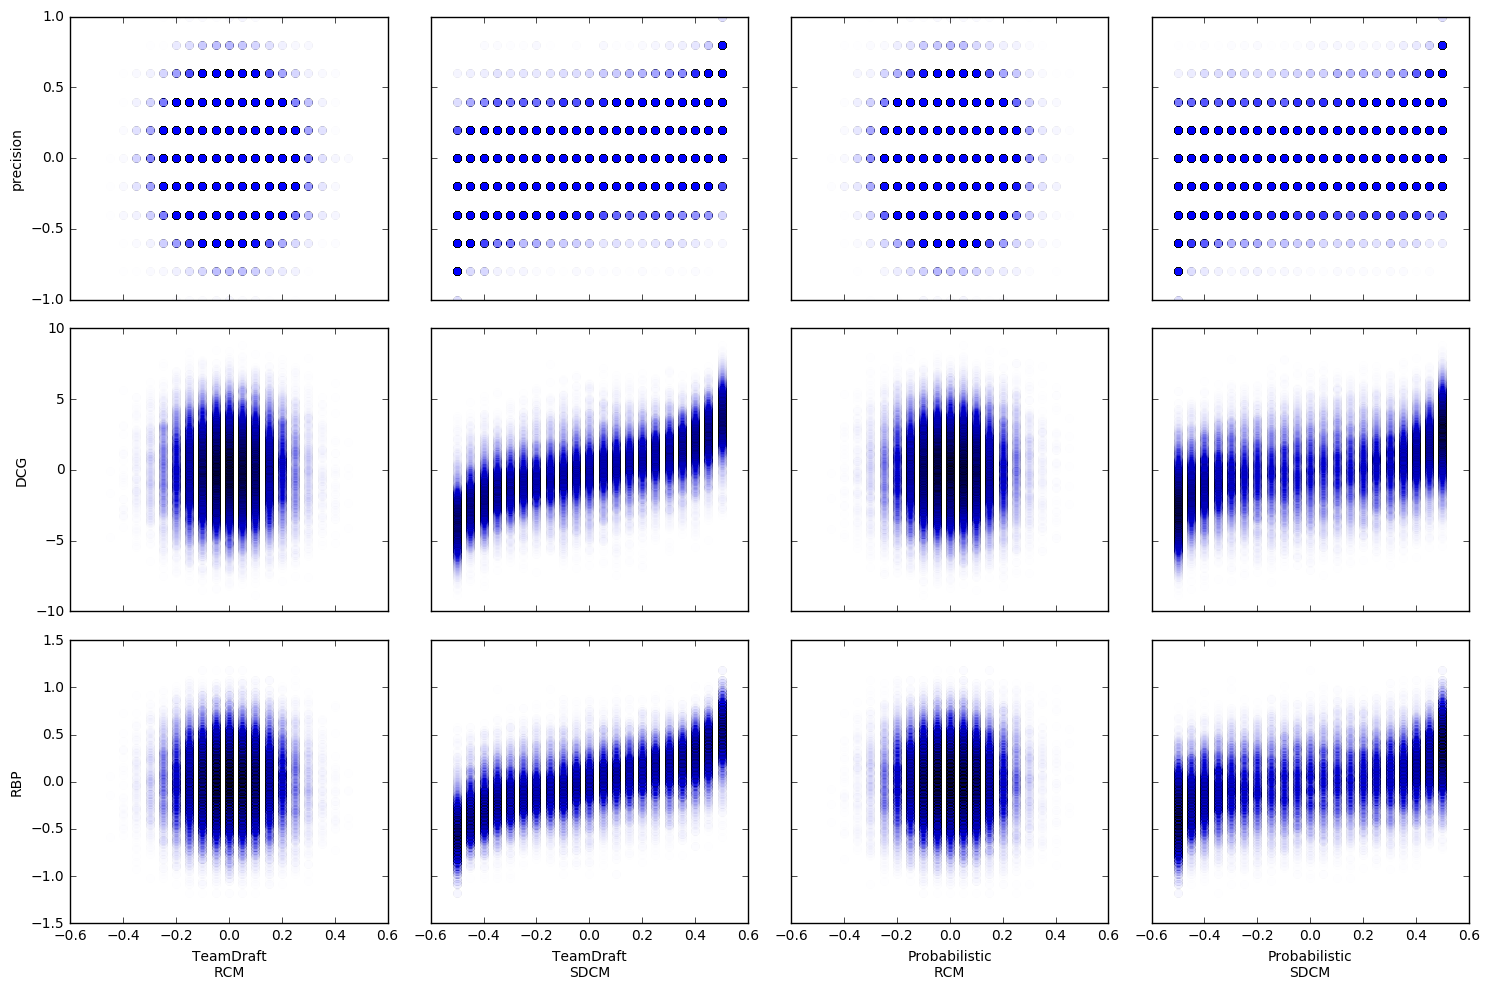

In [141]:
offline_names = ['precision','DCG', 'RBP']

f, (ax) = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(15, 10))

for offline_ind in range(3):
    offline_scores_vals = map(lambda x: x[0][offline_ind], scores) #map(lambda x: x[1], offline_scores)
    i = 0

    ax[offline_ind][0].set_ylabel(offline_names[offline_ind])
    
    for interleaving_ind in range(2):
        for click_model_ind in range(2):
            online_scores_vals =  map(lambda x: x[1][interleaving_ind][click_model_ind], scores)
            ax[offline_ind][i].plot(online_scores_vals, offline_scores_vals, 'bo', alpha=0.002)
            
            if offline_ind == 2:
                ax[offline_ind][i].set_xlabel(interleavings[interleaving_ind] + '\n' + clickModels[click_model_ind])
                
            i+=1
            plt.tight_layout()
plt.show()

In [137]:
off_names = ["Precision", "DCG", "RBP"]
interleave_names = ["Team Draft", "Probabilistic"]
cm_names = ["RCM", "SDCM"]


results_ca = []

for i in range(len(off_names)): #for each offline evaluation
    results_ca.append([])
    for j in range(len(interleave_names)): #for each interleaving algorithm
        for k in range(len(cm_names)): #for each click model
            
            xy = map(lambda x: (x[0][i],x[1][j][k]) , scores)
            x,y = zip(*xy)

            correlation =  numpy.corrcoef(x,y)[0][1]
            
            same = 0
            for t in range(len(x)):
                if numpy.sign(x[t]) == numpy.sign(y[t]): #-0.5 for wins_proportion
                    same+=1
            agreement = 1.0*same/len(x)
            
            results_ca[-1].append([correlation,agreement])
            
            print "Correlation for %s - %s-%s:"%(off_names[i],interleave_names[j],cm_names[k]), correlation        
            print "Agreement:", agreement
            

Correlation for Precision - Team Draft-RCM: 0.00106744301226
Agreement: 0.351013565005
Correlation for Precision - Team Draft-SDCM: 0.498535631347
Agreement: 0.532743992278
Correlation for Precision - Probabilistic-RCM: 0.00103505298849
Agreement: 0.351911124659
Correlation for Precision - Probabilistic-SDCM: 0.399869630878
Agreement: 0.492472353469
Correlation for DCG - Team Draft-RCM: -0.000932253032955
Agreement: 0.417229758336
Correlation for DCG - Team Draft-SDCM: 0.714108690419
Agreement: 0.750393740792
Correlation for DCG - Probabilistic-RCM: -0.000791900065383
Agreement: 0.416687835526
Correlation for DCG - Probabilistic-SDCM: 0.521007535391
Agreement: 0.663025622788
Correlation for RBP - Team Draft-RCM: -0.00114655324257
Agreement: 0.416535419736
Correlation for RBP - Team Draft-SDCM: 0.710225052994
Agreement: 0.742247963556
Correlation for RBP - Probabilistic-RCM: -0.0011680416651
Agreement: 0.415536249555
Correlation for RBP - Probabilistic-SDCM: 0.513550930794
Agreement: 0.

Wins Proportions

<table style="border-collapse:collapse;border-spacing:0;border-color:#ccc"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;text-align:center;vertical-align:top" rowspan="2">Correlation</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;vertical-align:top" colspan="2">Team Draft<br></th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;vertical-align:top" colspan="2">Probabilistic</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">RCM<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">SDCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">RCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">SDCM</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">Precision</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">-0.008</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.49</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">-0.004</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.39</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">DCG</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">-0.008</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.698</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">-0.005</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.51</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">RBP</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">-0.008</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.697</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">-0.004</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.501</td></tr></table>

<table style="border-collapse:collapse;border-spacing:0;border-color:#ccc"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;text-align:center;vertical-align:top" rowspan="2">Agreement<br></th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;vertical-align:top" colspan="2">Team Draft<br></th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;vertical-align:top" colspan="2">Probabilistic</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">RCM<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">SDCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">RCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">SDCM</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">Precision</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">35%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">52%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">35%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">48%</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">DCG</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">44%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">71%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">44%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">64%</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">RBP</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">44%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">70%<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">44%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">63%</td></tr></table>

Delta 

<table style="border-collapse:collapse;border-spacing:0;border-color:#ccc"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;text-align:center;vertical-align:top" rowspan="2">Correlation<br></th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;vertical-align:top" colspan="2">Team Draft<br></th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;vertical-align:top" colspan="2">Probabilistic</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">RCM<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">SDCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">RCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">SDCM</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">Precision</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.001</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.498</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.001</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.399</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">DCG</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.714<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.52<br></td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">RBP</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">-0.001</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.71<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">-.001<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">0.51</td></tr></table>

<table style="border-collapse:collapse;border-spacing:0;border-color:#ccc"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;text-align:center;vertical-align:top" rowspan="2">Agreement<br></th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;vertical-align:top" colspan="2">Team Draft<br></th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;vertical-align:top" colspan="2">Probabilistic</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">RCM<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">SDCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">RCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;vertical-align:top">SDCM</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">Precision</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">35%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">53%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">35%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">49%</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">DCG</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">41%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">75%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">41%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">66%</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">RBP</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">41%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">74%<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">41%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:13px 10px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">65%</td></tr></table>